# Reccurent Neural Networks

This colab notebook is an introduction to Reccurent Neural Networks.

Suppose we have sequence data like, stock price, DNA sequence or comments o reddit. There is some kind of dependence of observations, i.e. stock price can depend on history of prices, each comment has some dependence to previous comment as it can be a reply. To encode this dependence into NN we can use Reccurent variants of it.

![alt text](https://miro.medium.com/max/5200/1*tBUpKzl1F8FU5K_eKBYDHA.png)

Suppose we want to predict stock prices of Google at time $t$, while we have the data on stock price of Google, Microsoft and Apple until time $t-1$ included. 

FFNN neuron has the following mathematical formulation.
$$h_t = \sigma(w_1x_{Gt}+w_2x_{At}+w_3x_{Mt}+b)$$
while reccurent neuron has the following mathematical formulation.
$$h_t = \sigma(w_1x_{Gt}+w_2x_{At}+w_3x_{Mt}+b+w_hh_{t-1})$$

Let's unfold it.

$$IN_t = w_1x_{Gt}+w_2x_{At}+w_3x_{Mt}+b$$<br>
$$h_t = \sigma(IN_t+w_hh_{t-1})$$<br>
$$h_t = \sigma(IN_t+w_h\sigma(IN_{t-1}+w_hh_{t-2})$$<br>
$$h_t = \sigma(IN_t+w_h\sigma(IN_{t-1}+w_h\sigma(IN_{t-2}+w_hh_{t-3})$$<br>
$$...$$<br>
$$h_t = \sigma(IN_t+w_h\sigma(IN_{t-1}+w_h\sigma(...\sigma(IN_{0}+w_h\sigma(IN_{0}+0w_h)$$<br>

![alt text](https://miro.medium.com/max/2800/1*DItCSHJ-NA2wy4lFfXv-_Q.png)

The backpropogation of RNN is similar to FFNN. However, there is weight sharing as in CNNs.

![alt text](https://dudeperf3ct.github.io/images/rnn/backprop_3.png)

Let's make an assumption that stock price is not affected by prices older than a month. Then we can divide our dataset into 30 day length chunks and consider them as observations. 

In [0]:
import pandas_datareader.data as web
from pandas_datareader import get_data_yahoo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# getting stock daily data
google = get_data_yahoo('GOOGL')
microsoft = get_data_yahoo('MSFT')
apple = get_data_yahoo('AAPL')

In [0]:
# calculating daily differences
google['diff'] = google['Adj Close'] - google['Adj Close'].shift(1)
microsoft['diff'] = microsoft['Adj Close'] - microsoft['Adj Close'].shift(1)
apple['diff'] = apple['Adj Close'] - apple['Adj Close'].shift(1)

In [0]:
# converting to 30 day samples
google_list = google['diff'].to_list()[1:]
microsoft_list = microsoft['diff'].to_list()[1:]
apple_list = apple['diff'].to_list()[1:]
X = []
for i in range(len(google_list)-30):
    gnp = np.array(google_list[i:i+30]).reshape(30,1)
    mnp = np.array(microsoft_list[i:i+30]).reshape(30,1)
    anp = np.array(apple_list[i:i+30]).reshape(30,1)
    x = np.concatenate([gnp,mnp,anp]).reshape(30,3)
    X.append(x)
Y = np.array(google_list[30:]).reshape(-1,1)
X = np.array(X)

In [0]:
from tensorflow.keras.layers import SimpleRNN,Dense,Dropout,BatchNormalization,Input
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3)
X_train = X[:-300]
X_test = X[-300:]
Y_train = Y[:-300]
Y_test = Y[-300:]

In [0]:
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1,90))
X_train_scaled = scaler.transform(X_train.reshape(-1,90)).reshape(-1,30,3)
X_test_scaled = scaler.transform(X_test.reshape(-1,90)).reshape(-1,30,3)

scaler_y = StandardScaler()
scaler_y.fit(Y_train)
Y_train_scaled = scaler_y.transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128))
model.add(Dropout(0.8))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [0]:
model.fit(X_train_scaled,Y_train_scaled,
          batch_size = 64, epochs = 100, verbose = 1,
          validation_data= (X_test_scaled,Y_test_scaled))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 2169 samples, validate on 300 samples
Epoch 1/100
2169/2169 [==============================] - 3s 1ms/sample - loss: 3.5287 - val_loss: 4.7879
Epoch 2/100
2169/2169 [==============================] - 2s 725us/sample - loss: 2.7071 - val_loss: 4.6517
Epoch 3/100
2169/2169 [==============================] - 2s 707us/sample - loss: 1.8930 - val_loss: 4.7457
Epoch 4/100
2169/2169 [==============================] - 2s 718us/sample - loss: 1.5568 - val_loss: 4.8423
Epoch 5/100
2169/2169 [==============================] - 2s 747us/sample - loss: 1.4091 - val_loss: 4.7779
Epoch 6/100
2169/2169 [==============================] - 2s 776us/sample - loss: 1.2948 - val_loss: 4.7180
Epoch 7/100
2169/2169 [==============================] - 2s 815us/sample - loss: 1.2618 - val_loss: 4.7894
Epoch 8/100
2169/2169 [==============================] - 2s 795us/sample - loss: 1.1622 - val_loss: 4.7744
Epoch 9/100
2169/2

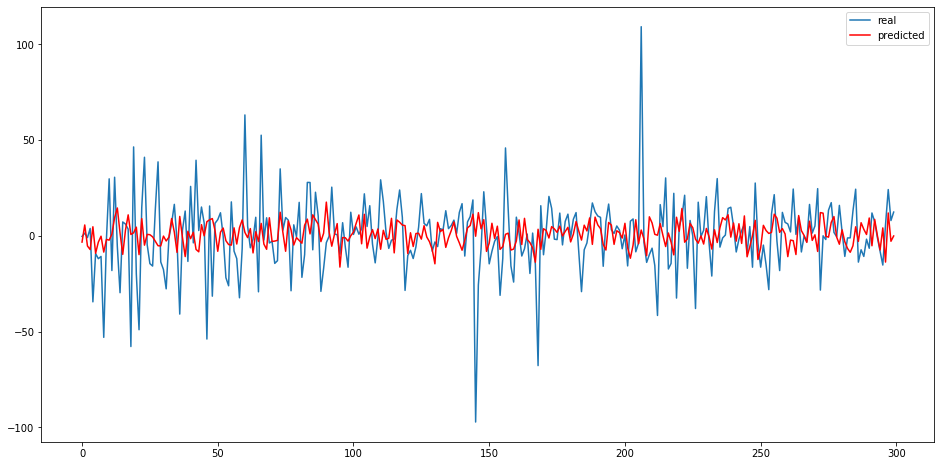

In [0]:
plt.figure(figsize = (10,4))
plt.plot(Y_test, label = 'real')
plt.plot(scaler_y.inverse_transform(model.predict(X_test_scaled)),
         'r',label = 'predicted')
plt.legend()
plt.show()

One of the problems with RNN is the vanishing and exploding gradient problem. When we apply sigmoid function over and over it either shrinks or explodes depending where we start. As in our example we apply more than 30 sigmoids to propogae the gradient it can be rather small or big.

![alt text](https://miro.medium.com/max/1400/1*gFC2bTg3uihp1klknWU0qg.gif)

To remedy this problem there are some variants of RNNs which try to add long term memory to neurons to preserve the gradients (like residual connections in ResNets). We will discuss those models in 2nd part.

on backprop http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/<br>
more on backprop with examples also on other RNNs https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html<br>
for other types https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [0]:
Y_train_bin = np.array([int(y>0) for y in Y_train])
Y_test_bin = np.array([int(y>0) for y in Y_test])

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

![alt text](http://i.imgur.com/J3DwxSF.png)

![alt text](https://i.stack.imgur.com/6VAOt.jpg)

In [0]:
model.fit(X_train_scaled,Y_train_bin,
          batch_size = 64, epochs = 10, verbose = 1,
          validation_data= (X_test_scaled,Y_test_bin))

Train on 2169 samples, validate on 300 samples
Epoch 1/10
2169/2169 [==============================] - 2s 1ms/sample - loss: 0.8153 - acc: 0.4961 - val_loss: 0.6964 - val_acc: 0.5300
Epoch 2/10
2169/2169 [==============================] - 2s 753us/sample - loss: 0.7726 - acc: 0.5127 - val_loss: 0.7130 - val_acc: 0.5133
Epoch 3/10
2169/2169 [==============================] - 2s 745us/sample - loss: 0.7730 - acc: 0.4961 - val_loss: 0.7003 - val_acc: 0.5400
Epoch 4/10
2169/2169 [==============================] - 2s 735us/sample - loss: 0.7445 - acc: 0.5178 - val_loss: 0.6931 - val_acc: 0.5567
Epoch 5/10
2169/2169 [==============================] - 2s 750us/sample - loss: 0.7397 - acc: 0.5284 - val_loss: 0.7047 - val_acc: 0.5167
Epoch 6/10
2169/2169 [==============================] - 2s 725us/sample - loss: 0.7253 - acc: 0.5413 - val_loss: 0.7003 - val_acc: 0.5500
Epoch 7/10
2169/2169 [==============================] - 2s 720us/sample - loss: 0.7105 - acc: 0.5357 - val_loss: 0.7065 - val_a

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['rise','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


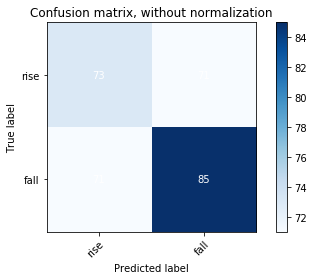

Normalized confusion matrix


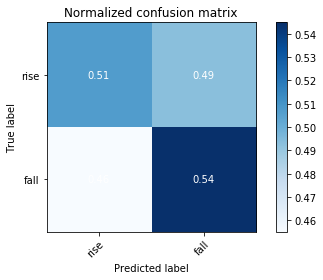

In [0]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test_bin, np.array([int(i>0.52) for i in model.predict(X_test_scaled)]),
                      classes=['rise','fall'],
                      title='Confusion matrix, without normalization')

plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(Y_test_bin, np.array([int(i>0.52) for i in model.predict(X_test_scaled)]),
                      classes=['rise','fall'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# LSTM & GRU

on LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/ also most images are from here

![aaa](LSTM.png)

# 1.Arachin@ vor katarvuma et long term memory ic forget a linum inch vor ban
# 2.Learn gate na vor@ short term memory n aysinqn naxord neuroni output u event irar het kpnumem vor learn anen nor ekac dataic u naxord pahi memory ic short inch ka ban
# 3.heto remember gate ov learn gate@ u forget gate@ kpnumen irar jogen inch remember arvi long term
# 4 verchum es uje forget gate@ kpnuma arden urish dzev learn gate in vor jogi short term inch output ani.

![aaaa](LSTM2.png)

As was established above, RNNs have vanishing and exploding gradient problem.

![alt text](https://miro.medium.com/max/1400/1*gFC2bTg3uihp1klknWU0qg.gif)

To remedy this problem some new architectures of RNNs have been developed. Let's start with LSTM (Long-Short-Term-Memory)

![alt text](http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png)

So one of main differences of LSTM to RNN is that each neuron has 2 types of states, _cell state_ and _hidden state_. Hidden state has the same purpose as RNNs hidden state. Cell state is responsible for long-term memory.


In LSTM there are several things added for each neuron.

![alt text](https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg)

![alt text](http://1.bp.blogspot.com/-toFzRVSExjk/Wsm3nL4B6II/AAAAAAAAq28/Pgm3feMiV-wCpNPS5akJnOz7r77rOg5RwCK4BGAYYCw/s1600/picture-778945.jpg)

The first equation $f_t = \sigma(W_f[h_{t-1},x_t]+b_f)$ is the _forget gate_. Forget gate is responsible for memorizing or forgeting long term information. It receives as an input previous hidden state and multiples information aggregrated from with long-term memory. Thus, it forces the neuron to remember/forget long-term information which is related to previous state.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

The second and third equations are the input gates. $i_t = \sigma(W_i[h_{t-1},x_t]+b_i)$, $\tilde{C}_t = tanh(W_C[h_{t-1},x_t]+b_C)$. The input gate is responsible for updating the long-term memory with new information.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

After passing through those 2 gates long-term memory is updated with the fourth equation $C_t = f_t*C_{t-1} + i_t*\tilde{C}_t$.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

The last 2 equations make the _output gate_. It's similar to simple RNNs case, however we also incroporate the information from the long-term memory.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

In [0]:
from tensorflow.keras.layers import LSTM,GRU

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128))
model.add(Dropout(0.8))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [0]:
model.fit(X_train_scaled,Y_train_scaled,
          batch_size = 64, epochs = 100, verbose = 1,
          validation_data= (X_test_scaled,Y_test_scaled))

Train on 2169 samples, validate on 300 samples
Epoch 1/100
2169/2169 [==============================] - 12s 6ms/sample - loss: 1.0043 - val_loss: 4.6534
Epoch 2/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 1.0072 - val_loss: 4.6256
Epoch 3/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 1.0069 - val_loss: 4.6234
Epoch 4/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.9993 - val_loss: 4.6308
Epoch 5/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.9986 - val_loss: 4.5750
Epoch 6/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 1.0009 - val_loss: 4.6345
Epoch 7/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.9931 - val_loss: 4.6145
Epoch 8/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.9949 - val_loss: 4.5990
Epoch 9/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.9953 - val_loss: 4.6611
Epoch 1

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch multiple                  12        
_________________________________________________________________
lstm (LSTM)                  multiple                  67584     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  131584    
_________________________________________________________________
lstm_2 (LSTM)                multiple                  131584    
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  129       
Total params: 330,893
Trainable params: 330,887
Non-trainable params: 6
________________________________________________

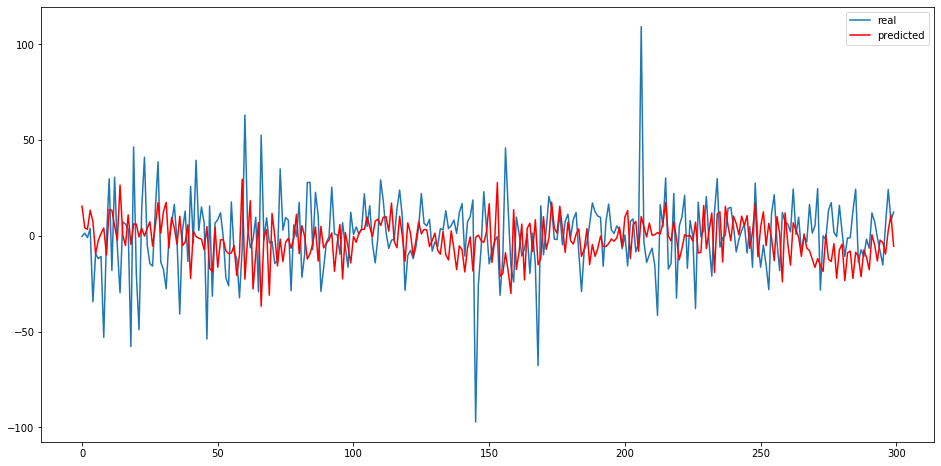

In [0]:
plt.figure(figsize = (10,4))
plt.plot(Y_test, label = 'real')
plt.plot(scaler_y.inverse_transform(model.predict(X_test_scaled)),
         'r',label = 'predicted')
plt.legend()
plt.show()

In [0]:
Y_train_bin = np.array([int(y>0) for y in Y_train])
Y_test_bin = np.array([int(y>0) for y in Y_test])

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128))
model.add(Dropout(0.8))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [0]:
model.fit(X_train_scaled,Y_train_bin,
          batch_size = 64, epochs = 100, verbose = 1,
          validation_data= (X_test_scaled,Y_test_bin))

Train on 2169 samples, validate on 300 samples
Epoch 1/100
2169/2169 [==============================] - 12s 5ms/sample - loss: 0.6929 - acc: 0.5104 - val_loss: 0.6968 - val_acc: 0.5133
Epoch 2/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.6951 - acc: 0.5104 - val_loss: 0.6897 - val_acc: 0.5400
Epoch 3/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.6927 - acc: 0.5256 - val_loss: 0.6937 - val_acc: 0.5267
Epoch 4/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.6943 - acc: 0.4915 - val_loss: 0.6946 - val_acc: 0.4900
Epoch 5/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.6901 - acc: 0.5302 - val_loss: 0.6926 - val_acc: 0.5200
Epoch 6/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.6936 - acc: 0.5187 - val_loss: 0.6952 - val_acc: 0.4967
Epoch 7/100
2169/2169 [==============================] - 9s 4ms/sample - loss: 0.6915 - acc: 0.5325 - val_loss: 0.6993 - val_acc: 

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch multiple                  12        
_________________________________________________________________
lstm_3 (LSTM)                multiple                  67584     
_________________________________________________________________
lstm_4 (LSTM)                multiple                  131584    
_________________________________________________________________
lstm_5 (LSTM)                multiple                  131584    
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  129       
Total params: 330,893
Trainable params: 330,887
Non-trainable params: 6
________________________________________________

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['rise','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


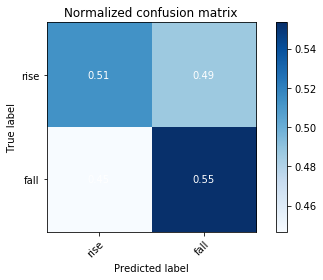

In [0]:
plot_confusion_matrix(Y_test_bin, [int(i>0.97) for i in model.predict(X_test_scaled)],
                      classes=['rise','fall'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Now let's examine GRU. A nice article on GRU: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

$z_t$ is responsible for weighing how much is previous information important than current information. $r_t$ is responsible on how much information should be forgeotten. $\tilde h_t$ is responsible for current information and $h_t$ is the final output which is a combination of current and previous information. 

GRU usually performs same as LSTM, but it has less parameters.

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128,return_sequences = True))
model.add(GRU(128,return_sequences = True))
model.add(GRU(128))
model.add(Dropout(0.8))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [0]:
model.fit(X_train_scaled,Y_train_scaled,
          batch_size = 64, epochs = 100, verbose = 1,
          validation_data= (X_test_scaled,Y_test_scaled))

Train on 2027 samples, validate on 300 samples
Epoch 1/100
2027/2027 [==============================] - 6s 3ms/step - loss: 1.0141 - val_loss: 5.4050
Epoch 2/100
2027/2027 [==============================] - 3s 2ms/step - loss: 1.0113 - val_loss: 5.4007
Epoch 3/100
2027/2027 [==============================] - 3s 2ms/step - loss: 1.0083 - val_loss: 5.4430
Epoch 4/100
2027/2027 [==============================] - 3s 2ms/step - loss: 1.0042 - val_loss: 5.4297
Epoch 5/100
2027/2027 [==============================] - 3s 2ms/step - loss: 1.0022 - val_loss: 5.4658
Epoch 6/100
2027/2027 [==============================] - 4s 2ms/step - loss: 1.0064 - val_loss: 5.5035
Epoch 7/100
2027/2027 [==============================] - 3s 2ms/step - loss: 1.0018 - val_loss: 5.5247
Epoch 8/100
2027/2027 [==============================] - 3s 2ms/step - loss: 0.9922 - val_loss: 5.5277
Epoch 9/100
2027/2027 [==============================] - 3s 2ms/step - loss: 0.9956 - val_loss: 5.5536
Epoch 10/100
2027/2027 [==

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 30, 3)             12        
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 128)           50688     
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 128)           98688     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 248,205
Trainable params: 248,199
Non-trainable params: 6
_________________________________________________________________


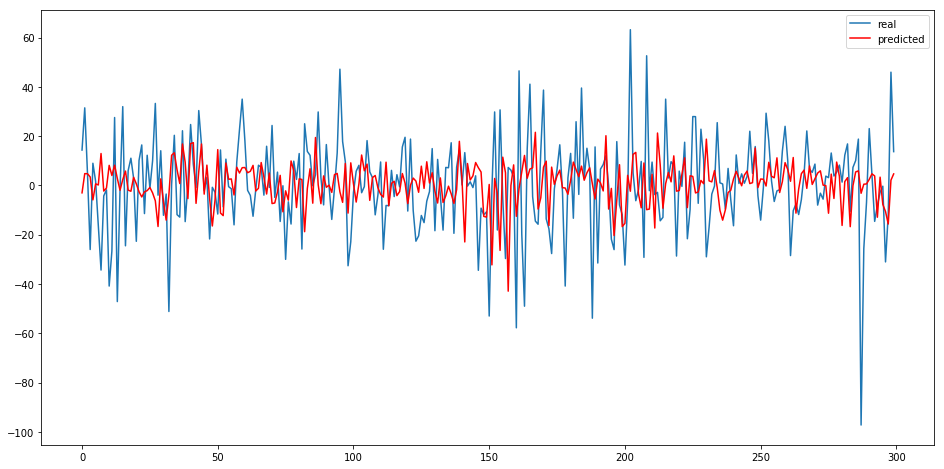

In [0]:
plt.figure(figsize = (10,4))
plt.plot(Y_test, label = 'real')
plt.plot(scaler_y.inverse_transform(model.predict(X_test_scaled)),
         'r',label = 'predicted')
plt.legend()
plt.show()

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128,return_sequences = True))
model.add(GRU(128,return_sequences = True))
model.add(GRU(128))
model.add(Dropout(0.8))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [0]:
model.fit(X_train_scaled,Y_train_bin,
          batch_size = 64, epochs = 100, verbose = 1,
          validation_data= (X_test_scaled,Y_test_bin))

Train on 2027 samples, validate on 300 samples
Epoch 1/100
2027/2027 [==============================] - 7s 3ms/step - loss: 0.6998 - acc: 0.4933 - val_loss: 0.6919 - val_acc: 0.5033
Epoch 2/100
2027/2027 [==============================] - 4s 2ms/step - loss: 0.6973 - acc: 0.4943 - val_loss: 0.6943 - val_acc: 0.5300
Epoch 3/100
2027/2027 [==============================] - 4s 2ms/step - loss: 0.6940 - acc: 0.5146 - val_loss: 0.6948 - val_acc: 0.5067
Epoch 4/100
2027/2027 [==============================] - 4s 2ms/step - loss: 0.6928 - acc: 0.5323 - val_loss: 0.6985 - val_acc: 0.5233
Epoch 5/100
2027/2027 [==============================] - 4s 2ms/step - loss: 0.6942 - acc: 0.5131 - val_loss: 0.6978 - val_acc: 0.5067
Epoch 6/100
2027/2027 [==============================] - 4s 2ms/step - loss: 0.6936 - acc: 0.5220 - val_loss: 0.6967 - val_acc: 0.5133
Epoch 7/100
2027/2027 [==============================] - 4s 2ms/step - loss: 0.6950 - acc: 0.5091 - val_loss: 0.7004 - val_acc: 0.5067
Epoch 8/

Normalized confusion matrix


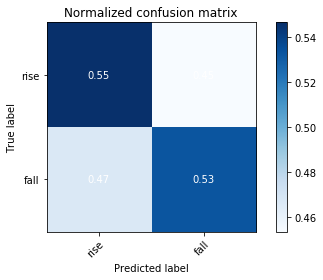

In [0]:
plot_confusion_matrix(Y_test_bin, [int(i>0.97) for i in model.predict(X_test_scaled)],
                      classes=['rise','fall'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

More exploration on LSTMs: http://blog.echen.me/2017/05/30/exploring-lstms/<br>
More on RNNs: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

more on backprop with examples also on other RNNs https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html<br>
more on LSTM and GRU https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [0]:
sentences = """I ate dinner.
We had a three-course meal.
Brad came to dinner with us.
He loves fish tacos.
In the end, we all felt like we ate too much.
We all agreed; it was a magnificent evening.
I hope that, when I've built up my savings, I'll be able to travel to Mexico.
Did you know that, along with gorgeous architecture, it's home to the largest tamale?
Wouldn't it be lovely to enjoy a week soaking up the culture?
Oh, how I'd love to go!
Of all the places to travel, Mexico is at the top of my list.
Would you like to travel with me?
Isn't language learning fun?
There is so much to understand.
I love learning!
Sentences come in many shapes and sizes.
Nothing beats a complete sentence.
Once you know all the elements, it's not difficult to pull together a sentence."""

In [0]:
sentences = sentences.split('\n')

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking,Embedding

In [0]:
# vocab is the size of vocabulary, tokenizer automatically drops
# infrequent words and replaces them with oov_token
vocab = 50
tokenizer = Tokenizer(num_words = vocab, oov_token='dummy')

In [0]:
tokenizer.fit_on_texts(sentences)

In [0]:
# 1 is always the dummy token
tokenized = tokenizer.texts_to_sequences(sentences)

In [0]:
# post padding
pad_sequences(tokenized,padding='post')

array([[ 7, 11, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 29,  4, 30, 31, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [33, 34,  2, 12,  8, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [36, 37, 38, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [13,  3, 40,  5,  6, 41, 14,  5, 11, 42, 15,  0,  0,  0,  0,  0],
       [ 5,  6, 43, 16, 44,  4, 45, 46,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7, 47, 17, 48, 49,  1, 18, 19,  1,  1, 20,  1,  2,  9,  2, 21],
       [ 1, 10, 22, 17,  1,  8,  1,  1, 23,  1,  2,  3,  1,  1,  0,  0],
       [ 1, 16, 20,  1,  2,  1,  4,  1,  1, 18,  3,  1,  0,  0,  0,  0],
       [ 1,  1,  1, 24,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [25,  6,  3,  1,  2,  9, 21, 26,  1,  3,  1, 25, 19,  1,  0,  0],
       [ 1, 10, 14,  2,  9,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1, 27,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 26,  1, 15,  2,  1,  0,  0,  0,  0,  0,

In [0]:
# pre padding
pad_sequences(tokenized,padding='pre')

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 11, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 29,  4, 30, 31, 32],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33, 34,  2, 12,  8, 35],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 37, 38, 39],
       [ 0,  0,  0,  0,  0, 13,  3, 40,  5,  6, 41, 14,  5, 11, 42, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  5,  6, 43, 16, 44,  4, 45, 46],
       [ 7, 47, 17, 48, 49,  1, 18, 19,  1,  1, 20,  1,  2,  9,  2, 21],
       [ 0,  0,  1, 10, 22, 17,  1,  8,  1,  1, 23,  1,  2,  3,  1,  1],
       [ 0,  0,  0,  0,  1, 16, 20,  1,  2,  1,  4,  1,  1, 18,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, 24,  2,  1],
       [ 0,  0, 25,  6,  3,  1,  2,  9, 21, 26,  1,  3,  1, 25, 19,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 10, 14,  2,  9,  8,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, 27,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,

In [0]:
padded = pad_sequences(tokenized,padding='post')
max_len = padded.shape[1] # the maximum a sentence can be

In [0]:
model = Sequential()
# Masking layer masks the values of 0s so they are not calculated
model.add(Masking(mask_value=0., input_shape=(max_len,)))
# embedding layer is very much like Dense but is exploiting the information
# that it only recieves one hot vectors and becomes just a look up table
model.add(Embedding(vocab, 8, input_length=None)) 
# we can do it in shorter version
# model.add(Embedding(vocab, 8, input_length=None, mask_zero = True)) 
model.add(BatchNormalization())
model.add(GRU(128,return_sequences = True))
model.add(GRU(128,return_sequences = True))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [0]:
model.fit(padded,np.zeros(18),
          batch_size = 8, epochs = 10, verbose = 1)

Train on 18 samples
Epoch 1/10
18/18 [==============================] - 2s 124ms/sample - loss: 0.6243 - acc: 0.8333
Epoch 2/10
18/18 [==============================] - 0s 13ms/sample - loss: 0.3223 - acc: 1.0000
Epoch 3/10
18/18 [==============================] - 0s 15ms/sample - loss: 0.0826 - acc: 1.0000
Epoch 4/10
18/18 [==============================] - 0s 13ms/sample - loss: 0.0101 - acc: 1.0000
Epoch 5/10
18/18 [==============================] - 0s 13ms/sample - loss: 0.0011 - acc: 1.0000
Epoch 6/10
18/18 [==============================] - 0s 13ms/sample - loss: 3.6161e-04 - acc: 1.0000
Epoch 7/10
18/18 [==============================] - 0s 13ms/sample - loss: 1.5872e-04 - acc: 1.0000
Epoch 8/10
18/18 [==============================] - 0s 13ms/sample - loss: 7.5121e-05 - acc: 1.0000
Epoch 9/10
18/18 [==============================] - 0s 13ms/sample - loss: 1.4525e-05 - acc: 1.0000
Epoch 10/10
18/18 [==============================] - 0s 13ms/sample - loss: 2.2673e-06 - acc: 1.000

### Exercise
Try LSTM and GRU on imdb dataset